In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns
sns.set(style='ticks', context='talk')
% matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# from statsmodels import ConvergenceWarning
# warnings.simplefilter(action='ignore', category='ConvergenceWarning')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as tsa

import sys, os, copy
print("Using environment in "+sys.prefix)
print("Python version "+sys.version)

Using environment in /Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env
Python version 3.5.2 (default, Oct 31 2016, 16:50:28) 
[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]


In [2]:
fname = 'Metro_Zhvi_AllHomes.csv'

#  Map Zillow RegionID to metro area string
metroRegionID = {'Dallas-Fort Worth, TX':394514,
                     'Atlanta, GA':394347,
                     'Phoenix, AZ':394976,
                     'Las Vegas, NV':394775 }

metroString = {'Dallas':u'Dallas-Fort Worth, TX',
               'Atlanta':u'Atlanta, GA',
               'Phoenix':u'Phoenix, AZ',
               'Vegas':u'Las Vegas, NV'}

df = pd.read_csv('Data/ZHVI/'+fname,index_col=[1])
df = df.drop(['RegionID','SizeRank'],axis=1)
df.columns = pd.DatetimeIndex(df.columns)

In [10]:
cityList = list(metroString.keys())
cityList.sort()
startDate = None #'2004-01-01'
endDate   = None

shiftMonths = 6
city = 'Phoenix'
ts = df.loc[metroString[city],startDate:endDate]

In [4]:
def getRMSE(x,y):
    # X: Pandas TimeSeries of actual data
    # Y: Either a Pandas TimeSeries of prediction data, OR a Pandas DataFrame with each column as different series 
    diff = x - y
    
    if type(y)== pd.core.series.Series:
        return np.sqrt(diff.pow(2).sum()/diff.count())
    else:
        return np.sqrt(diff.pow(2).sum(axis=0) / diff.count(axis=0))

In [12]:
import pickle
metroMonthly = pickle.load(open('Data/Summary/metroMonthly.pkl','rb'))
nationalMonthly = pickle.load(open('Data/Summary/nationalMonthly.pkl','rb'))

In [54]:
metroMonthly['Atlanta'].tail()

,metroUnemployment,metroLaborForce,stateInitialUnemplClaims,stateContinuedUnemplClaims,stateLaborForce,pricecut,inventory,sold4Loss,rentMultifam,price2rent,rentSFR,rentAllHomes,inventoryAge,sold4Gain,daysOnZillow,metroIncome
2017-01-01,5.145781,2986019.0,34056.0,147473.0,4113981.0,11.441704,30192.0,20.73,1312.0,10.93,1335.0,1334.0,97.0,79.27,92.875,62819.215525
2017-02-01,4.919896,3001283.0,24923.0,131413.0,4122685.0,11.871459,29447.0,19.13,1312.0,10.95,1337.0,1336.0,94.0,80.87,88.000,62961.958258
2017-03-01,4.758290,3010094.0,20695.0,116337.0,4131389.0,11.951203,28324.0,15.32,1312.0,10.98,1339.0,1338.0,69.0,84.68,74.500,63104.700991
2017-04-01,4.795109,3015281.0,27676.0,138866.0,4140093.0,11.529395,27516.0,13.86,1314.0,11.00,1342.0,1342.0,58.0,86.14,64.500,NaN
2017-05-01,4.728334,3018886.0,21849.0,110991.0,4149149.0,12.396958,27239.0,11.90,1318.0,11.03,1345.0,1344.0,55.0,88.10,61.000,NaN


In [61]:
city='Atlanta'
startDate = '2011-01'
endDate = '2017-03'
ts = df.loc[metroString[city],startDate:endDate]

metroData = metroMonthly[city].loc[ts.index[0]:ts.index[-1],:]
metroData = metroData.dropna(axis=1, how='any')
metroData.shape

(75, 15)

In [66]:
exogVars.head()

,metroUnemployment,metroLaborForce,stateLaborForce,pricecut,inventory,foreclosures,rentMultifam,price2rent,rentSFR,daysOnZillow,metroIncome,csi,cpi,natLaborForce
2011-01-01,1.539759,0.970698,0.956434,1.393692,1.694463,2.481796,0.998358,0.781737,0.995697,1.197655,1.001784,0.857287,0.941379,0.954760
2011-02-01,1.523546,0.972032,0.955175,1.366600,1.712431,2.239805,0.999468,0.772923,0.997310,1.208822,0.999149,0.910736,0.946021,0.954733
2011-03-01,1.510873,0.974259,0.953916,1.398541,1.772683,2.815234,0.998358,0.762347,0.998924,1.141820,0.996514,0.864623,0.955246,0.954707
2011-04-01,1.501993,0.975676,0.952657,1.180645,1.851897,3.254603,0.993921,0.750009,1.000538,1.063652,0.993660,0.864623,0.961397,0.954681
2011-05-01,1.493044,0.975959,0.952020,1.145810,1.865049,3.725583,0.988375,0.741196,1.001345,1.041318,0.990806,0.858335,0.965920,0.955233


/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/emunsing/Documents/Coding/github/cdips_hpi_forecast/env/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


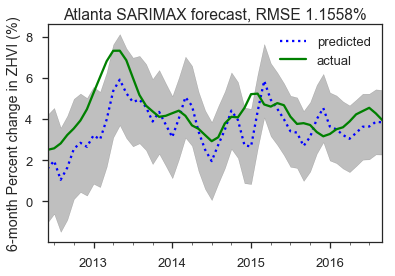

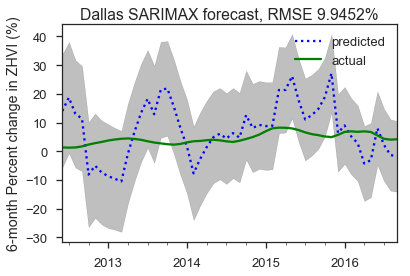

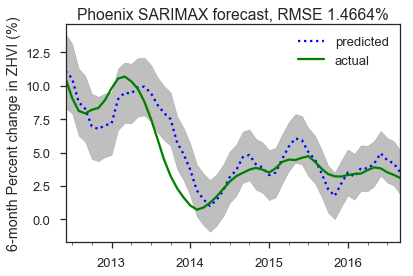

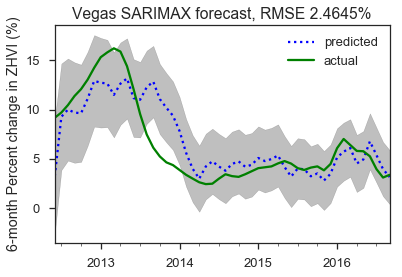

In [76]:
startDate = '2011-01'
endDate = '2017-03'

exogVars = None
scaleBy  = 1.0

for city in cityList: #['Atlanta']: 
    ts = df.loc[metroString[city],startDate:endDate]
    y = ts

    ## Exogenous Variables
    # Compile exogenous variables for that city
    metroData = metroMonthly[city].loc[ts.index[0]:ts.index[-1],:]
    metroData = metroData.dropna(axis=1, how='any')
    natlData  = nationalMonthly.loc[ts.index[0]:ts.index[-1],:]
    natlData  = natlData.dropna(axis=1, how='any')
    exogVars  = metroData.join(natlData)
#     exogVars  = exogVars[['stateInitialUnemplClaims','stateContinuedUnemplClaims']]
#     exogVars  = exogVars.drop(['stateInitialUnemplClaims','stateContinuedUnemplClaims'], axis=1)
    exogVars  = exogVars / exogVars.mean(axis=0) # Scale to unit in order to avoid bad conditioning
    
    if exogVars is not None:
        scaleBy = ts.mean()
    
    ## Data prep
    y = y / scaleBy
    trainUntil    = '2012-05'
    trainEndIndex = y.index.get_loc(trainUntil).stop
    trainingEnds  = y.index[trainEndIndex]
    testingStarts = y.index[trainEndIndex + shiftMonths - 1]
    trainDateList = y.loc[trainingEnds:,].index
    testDateList  = y.loc[testingStarts:,].index

    results = pd.DataFrame(index=trainDateList, columns=['lower','predicted','upper'])

    model=smt.SARIMAX(y, order=(12, 2, 12), exog=exogVars, enforce_invertibility=False, enforce_stationarity=False)
    res=model.fit()


    for i in range(len(testDateList)):
        testDate = testDateList[i]
        myForecast = res.get_prediction(start=trainDateList[i],dynamic=True)  # This will run rolling predictions based on the fitted model

        # We want to pull the mean prediction and confidence interval data for the forecast prices n-months into the future
        results.loc[testDate,['lower','upper']] = myForecast.conf_int().loc[testDate,:].values * scaleBy # This is the forecast for the future date
        results.loc[testDate,'predicted'] = myForecast.predicted_mean.loc[testDate] * scaleBy

    scaledResults = results.shift(-shiftMonths,axis=0).divide(ts,axis=0) - 1
    scaledResults = scaledResults * 100
    scaledResults.dropna(inplace=True)

    # Create the ground-truth against which we're comparing this
    actual = ts.pct_change(periods=shiftMonths).shift(-shiftMonths).dropna() * 100
    actual.name = 'actual'
    scaledResults = scaledResults.join(actual,how='inner').dropna()

    ## Plot results 
    ax = scaledResults[['predicted','actual']].plot(style=['b:','g-'])
    ax.set_ylabel('6-month Percent change in ZHVI (%)')
    plt.title('%s SARIMAX forecast, RMSE %.4f%%'%(city,getRMSE(scaledResults['predicted'],scaledResults['actual'])))
    ax.fill_between(scaledResults.index, list(scaledResults['lower'].values), list(scaledResults['upper'].values),color='k',alpha=0.25)

# The rest of this notebook is a big mistake...
Based on Jeff's insight, I'm realizing that we can't just use the 6-month lagged data as our predictor and step forwards one month, because that has information about the data 5 months out. Instead, we need to predict the actual data 6 months ahead.

I don't see a good or relevant way to do this by using the percent change data, and instead think that we need to use the raw data and a dynamic forecast.

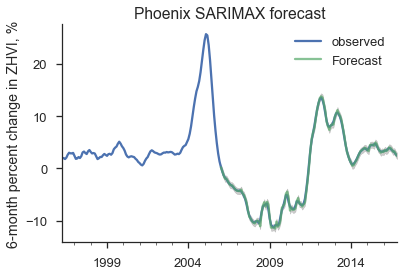

In [157]:
## Basic SARIMAX on percent change over 6 months
y = ts.pct_change(periods=shiftMonths).shift(-shiftMonths).dropna()*100

model=smt.SARIMAX(y, trend='c', order=(1, 1, 1))
res=model.fit()
pred = res.get_prediction(start='2006-01-01')
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('%s SARIMAX forecast'%city)
plt.ylabel("6-month percent change in ZHVI, %")
plt.legend()
sns.despine()


In [103]:
## Compare results for all cities

cityList = list(metroString.keys())
cityList.sort()
startDate = None #'2004-01-01'
endDate   = None

monthsForwards = 6

for city in cityList:
    ts = df.loc[metroString[city],startDate:endDate]
    y = ts.pct_change(periods=monthsForwards).shift(-monthsForwards).dropna()*100

    model=smt.SARIMAX(y, trend='c', order=(1, 1, 1))
    res=model.fit()
    pred = res.get_prediction(start='2006-01-01')
    print("Prediction error for %s: %.4f %%"%(city,getRMSE(y,pred.predicted_mean)))


Prediction error for Atlanta: 0.2585 %
Prediction error for Dallas: 0.3280 %
Prediction error for Phoenix: 0.3114 %
Prediction error for Vegas: 0.3492 %


In [148]:
# Validation: Walk-forwards, increasing our training set by one month at a time.
#  This helps me rest assured that the model is actually predicting out-of-sample.

results = pd.DataFrame()

trainUntil    = '2005-12'
trainEndIndex = y.index.get_loc(trainUntil).stop
trainingEnds  = y.index[trainEndIndex-1]
testingStarts = y.index[trainEndIndex]
testDateList  = y.loc[testingStarts:,].index

for testDate in testDateList:

    trainSet = y.loc[:trainingEnds]
    model=smt.SARIMAX(trainSet, trend='c', order=(1, 1, 1))
    res=model.fit()
    myForecast = res.forecast()
    results.loc[testDate,city] = myForecast[testDate]
    
    trainingEnds = testDate